# Basis Capacity Sweep with ADAM

This notebook sweeps the number of CRAB basis functions for the transverse (K_omega) and detuning (K_delta) channels when optimizing the same GRAPE cost function with the ADAM optimizer.

We reuse the pulse shapes and penalties from earlier step-size experiments and collect per-run metrics (cost, runtime, gradient norms) to quantify how basis capacity changes convergence.

**Sweep definition**

- K_omega ? {4, 8, 16, 24}
- K_delta ? {0, 4, 8}
- Deterministic setup (no random seeds), 5 minute runtime budget, ADAM hyperparameters fixed across runs.

In [12]:
# Imports
from pathlib import Path
import sys
import os

notebook_dir = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
repo_root = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir
if str(repo_root) not in map(str, sys.path):
    sys.path.insert(0, str(repo_root))
os.chdir(repo_root)

from typing import Any, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src import override_from_dict, run_experiment
from src.notebook_runners import (
    build_base_config,
    method_options,
    prepare_baseline,
)


In [13]:
# Experiment parameters
max_iters = 500
grad_tol = 1e-10
rtol = 1e-10
max_time_min = 5.0

adam_learning_rate = 0.5
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
lr_decay = 1.0

power_weight = 5.0e-5
neg_weight = 1.0
neg_kappa = 10.0

artifact_root = Path('./artifacts')
run_name_base = 'basis-capacity-sweep'
objective = 'terminal'

K_OMEGA_VALUES = (4, 8, 16, 24)
K_DELTA_VALUES = (0, 4, 8)

omega_shape = {'kind': 'polynomial', 'area_pi': 3.3}
delta_shape = {'kind': 'linear_chirp', 'area_pi': 0.0, 'amplitude_scale': 40.0}

BASE_OPTIMIZER_COMMON = {
    'max_iters': int(max_iters),
    'grad_tol': float(grad_tol),
    'rtol': float(rtol),
    'max_time_s': float(max_time_min) * 60.0,
}

ADAM_OVERRIDES = {
    'learning_rate': float(adam_learning_rate),
    'beta1': float(beta1),
    'beta2': float(beta2),
    'epsilon': float(epsilon),
    'lr_decay': float(lr_decay),
}

PENALTIES = {
    'power_weight': float(power_weight),
    'neg_weight': float(neg_weight),
    'neg_kappa': float(neg_kappa),
}


In [14]:
# Helper utilities
def extract_history_series(history: Dict[str, Any]) -> Dict[str, np.ndarray | None]:
    def _pull(key: str, dtype=float):
        series = history.get(key)
        if series is None:
            return None
        arr = np.asarray(series, dtype=dtype)
        return arr if arr.size else None

    return {
        'iter': _pull('iter', dtype=np.int64),
        'cost_total': _pull('total', dtype=float),
        'cost_terminal': _pull('terminal', dtype=float),
        'cost_power': _pull('power_penalty', dtype=float),
        'cost_neg': _pull('neg_penalty', dtype=float),
        'grad_norm': _pull('grad_norm', dtype=float),
        'step_norm': _pull('step_norm', dtype=float),
        'lr': _pull('lr', dtype=float),
        'calls_per_iter': _pull('calls_per_iter', dtype=np.int64),
    }


def summarize_adam_result(result) -> tuple[Dict[str, Any], Dict[str, np.ndarray | None]]:
    history_map = extract_history_series(result.history)
    total_series = history_map.get('cost_total')
    iterations = int(total_series.size) if total_series is not None else 0

    grad_series = history_map.get('grad_norm')
    grad_final = float(grad_series[-1]) if grad_series is not None and grad_series.size else float('nan')
    step_series = history_map.get('step_norm')
    step_final = float(step_series[-1]) if step_series is not None and step_series.size else float('nan')
    calls_series = history_map.get('calls_per_iter')
    oracle_calls = int(np.asarray(calls_series, dtype=np.int64).sum()) if calls_series is not None else 0

    metrics = result.final_metrics
    pulses = result.pulses
    omega_final = np.asarray(pulses.get('omega'), dtype=np.float64)
    t_us = np.asarray(pulses.get('t_us'), dtype=np.float64)

    summary = {
        'total_final': float(metrics.get('total', np.nan)),
        'terminal_final': float(metrics.get('terminal', np.nan)),
        'power_final': float(metrics.get('power_penalty', 0.0)),
        'neg_final': float(metrics.get('neg_penalty', 0.0)),
        'runtime_s': float(metrics.get('runtime_s', np.nan)),
        'iterations': iterations,
        'grad_norm_final': grad_final,
        'step_norm_final': step_final,
        'oracle_calls': oracle_calls,
        'max_abs_omega': float(np.max(np.abs(omega_final))) if omega_final.size else float('nan'),
        'area_omega_over_pi': float(np.trapezoid(np.abs(omega_final), t_us) / np.pi) if omega_final.size and t_us.size else float('nan'),
        'negativity_fraction': float(np.mean(omega_final < 0.0)) if omega_final.size else float('nan'),
        'run_name': result.run_name,
        'artifacts_dir': str(result.artifacts_dir),
    }

    status_info = result.optimizer_state or {}
    status = str(status_info.get('status', 'unknown'))
    summary['status'] = status
    summary['status_detail'] = status
    return summary, history_map


In [15]:
# Run ADAM sweep over (K_omega, K_delta) pairs
sweep_records: list[Dict[str, Any]] = []
history_by_basis: Dict[Tuple[int, int], Dict[str, np.ndarray | None]] = {}
pulses_by_basis: Dict[Tuple[int, int], Dict[str, np.ndarray]] = {}

for K_omega in K_OMEGA_VALUES:
    for K_delta in K_DELTA_VALUES:
        run_label = f'{run_name_base}-Ko{K_omega:02d}-Kd{K_delta:02d}'
        print(f"[adam][Ko={K_omega:02d} Kd={K_delta:02d}] starting optimization")

        ctx = prepare_baseline(
            omega_shape=omega_shape,
            delta_shape=delta_shape if K_delta > 0 else None,
            K_omega=int(K_omega),
            K_delta=int(K_delta),
        )

        base_opts = dict(BASE_OPTIMIZER_COMMON)
        base_opts['optimize_delta'] = bool(K_delta > 0)

        base_config, base_options = build_base_config(
            ctx.config,
            run_name=run_label,
            artifact_root=artifact_root,
            penalties=PENALTIES,
            objective=objective,
            base_optimizer_options=base_opts,
        )

        adam_options = method_options('adam', base_options, ADAM_OVERRIDES)
        config = override_from_dict(base_config, {'optimizer_options': adam_options})

        result = run_experiment(
            config,
            method='adam',
            run_name=run_label,
            exist_ok=True,
        )

        summary, history_map = summarize_adam_result(result)
        summary['K_omega'] = int(K_omega)
        summary['K_delta'] = int(K_delta)
        sweep_records.append(summary)
        history_by_basis[(int(K_omega), int(K_delta))] = history_map
        pulses_by_basis[(int(K_omega), int(K_delta))] = {
            'omega': np.asarray(result.pulses.get('omega'), dtype=np.float64),
            'delta': None if result.pulses.get('delta') is None else np.asarray(result.pulses.get('delta'), dtype=np.float64),
            't_us': np.asarray(result.pulses.get('t_us'), dtype=np.float64),
        }

        print(f"[adam][Ko={K_omega:02d} Kd={K_delta:02d}] finished (status={summary['status']})")


[adam][Ko=04 Kd=00] starting optimization
[adam][Ko=04 Kd=00] finished (status=max_iters)
[adam][Ko=04 Kd=04] starting optimization
[adam][Ko=04 Kd=04] finished (status=max_iters)
[adam][Ko=04 Kd=08] starting optimization
[adam][Ko=04 Kd=08] finished (status=max_iters)
[adam][Ko=08 Kd=00] starting optimization
[adam][Ko=08 Kd=00] finished (status=max_iters)
[adam][Ko=08 Kd=04] starting optimization
[adam][Ko=08 Kd=04] finished (status=max_iters)
[adam][Ko=08 Kd=08] starting optimization
[adam][Ko=08 Kd=08] finished (status=max_iters)
[adam][Ko=16 Kd=00] starting optimization
[adam][Ko=16 Kd=00] finished (status=max_iters)
[adam][Ko=16 Kd=04] starting optimization
[adam][Ko=16 Kd=04] finished (status=max_iters)
[adam][Ko=16 Kd=08] starting optimization
[adam][Ko=16 Kd=08] finished (status=max_iters)
[adam][Ko=24 Kd=00] starting optimization
[adam][Ko=24 Kd=00] finished (status=max_iters)
[adam][Ko=24 Kd=04] starting optimization
[adam][Ko=24 Kd=04] finished (status=max_iters)
[adam][Ko=

In [16]:
# Compile summary table
summary_df = pd.DataFrame(sweep_records)
if not summary_df.empty:
    ordered_columns = [
        'K_omega',
        'K_delta',
        'status',
        'total_final',
        'terminal_final',
        'runtime_s',
        'iterations',
        'grad_norm_final',
        'step_norm_final',
        'oracle_calls',
        'max_abs_omega',
        'area_omega_over_pi',
        'negativity_fraction',
        'run_name',
        'artifacts_dir',
    ]
    available_columns = [col for col in ordered_columns if col in summary_df.columns]
    summary_df = summary_df[available_columns].sort_values(['K_delta', 'K_omega']).reset_index(drop=True)
summary_df


,K_omega,K_delta,status,total_final,terminal_final,runtime_s,iterations,grad_norm_final,step_norm_final,oracle_calls,max_abs_omega,area_omega_over_pi,negativity_fraction,run_name,artifacts_dir
0,4,0,max_iters,0.051402,0.000063,24.536989,500,0.000034,0.004226,500,134.419740,2.994943,0.000000,basis-capacity-sweep-Ko04-Kd00,artifacts\basis-capacity-sweep-Ko04-Kd00
1,8,0,max_iters,0.047036,0.000055,24.689297,500,0.000011,0.001827,500,119.728670,2.995262,0.000000,basis-capacity-sweep-Ko08-Kd00,artifacts\basis-capacity-sweep-Ko08-Kd00
2,16,0,max_iters,0.045528,0.000052,24.469241,500,0.000022,0.003101,500,113.399282,2.995411,0.000000,basis-capacity-sweep-Ko16-Kd00,artifacts\basis-capacity-sweep-Ko16-Kd00
3,24,0,max_iters,0.045107,0.000051,24.965085,500,0.000022,0.003059,500,111.726877,2.995449,0.000000,basis-capacity-sweep-Ko24-Kd00,artifacts\basis-capacity-sweep-Ko24-Kd00
4,4,4,max_iters,0.022147,0.000079,25.533880,500,0.001788,0.140825,500,71.662431,1.320389,0.024988,basis-capacity-sweep-Ko04-Kd04,artifacts\basis-capacity-sweep-Ko04-Kd04
5,8,4,max_iters,0.005989,0.000006,24.331053,500,0.000054,0.009790,500,39.732291,0.998956,0.000000,basis-capacity-sweep-Ko08-Kd04,artifacts\basis-capacity-sweep-Ko08-Kd04
6,16,4,max_iters,0.005854,0.000005,24.597102,500,0.000149,0.029170,500,40.246257,0.999159,0.000000,basis-capacity-sweep-Ko16-Kd04,artifacts\basis-capacity-sweep-Ko16-Kd04
7,24,4,max_iters,0.005806,0.000005,24.734093,500,0.000179,0.032514,500,41.259760,0.999184,0.000000,basis-capacity-sweep-Ko24-Kd04,artifacts\basis-capacity-sweep-Ko24-Kd04
8,4,8,max_iters,0.026703,0.000114,25.387705,500,0.001607,0.119209,500,76.211760,1.490603,0.021989,basis-capacity-sweep-Ko04-Kd08,artifacts\basis-capacity-sweep-Ko04-Kd08
9,8,8,max_iters,0.005714,0.000006,24.469832,500,0.000067,0.012243,500,39.182536,0.998546,0.000000,basis-capacity-sweep-Ko08-Kd08,artifacts\basis-capacity-sweep-Ko08-Kd08


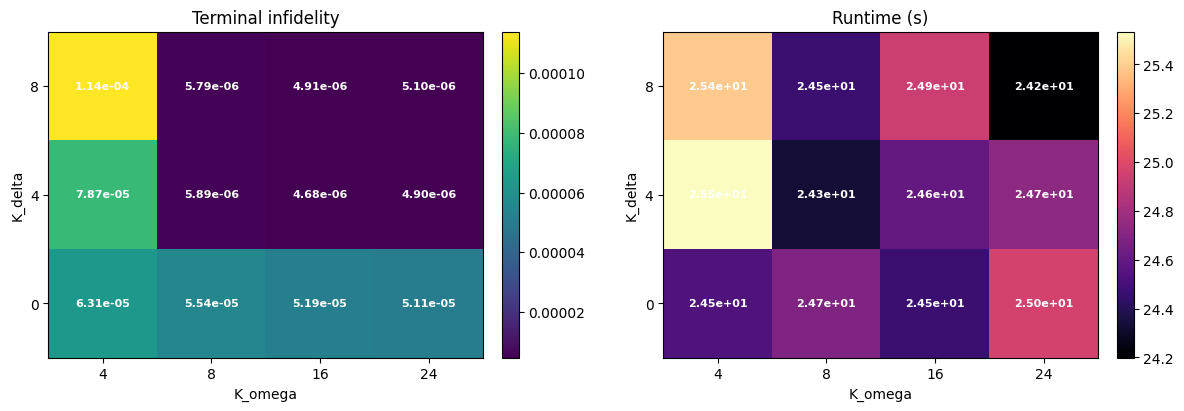

In [17]:
# Heatmaps for terminal infidelity and runtime
if not summary_df.empty:
    pivot_terminal = summary_df.pivot(index='K_delta', columns='K_omega', values='terminal_final')
    pivot_runtime = summary_df.pivot(index='K_delta', columns='K_omega', values='runtime_s')

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
    ims = [
        axes[0].imshow(pivot_terminal.values, origin='lower', cmap='viridis'),
        axes[1].imshow(pivot_runtime.values, origin='lower', cmap='magma'),
    ]
    axes[0].set_title('Terminal infidelity')
    axes[1].set_title('Runtime (s)')

    for ax, pivot in zip(axes, [pivot_terminal, pivot_runtime]):
        ax.set_xticks(range(pivot.shape[1]))
        ax.set_xticklabels(pivot.columns)
        ax.set_yticks(range(pivot.shape[0]))
        ax.set_yticklabels(pivot.index)
        ax.set_xlabel('K_omega')
        ax.set_ylabel('K_delta')
        for (i, j), value in np.ndenumerate(pivot.values):
            ax.text(j, i, f"{value:.2e}", ha='center', va='center', color='white', fontsize=8, fontweight='bold')
    for ax, im in zip(axes, ims):
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.show()


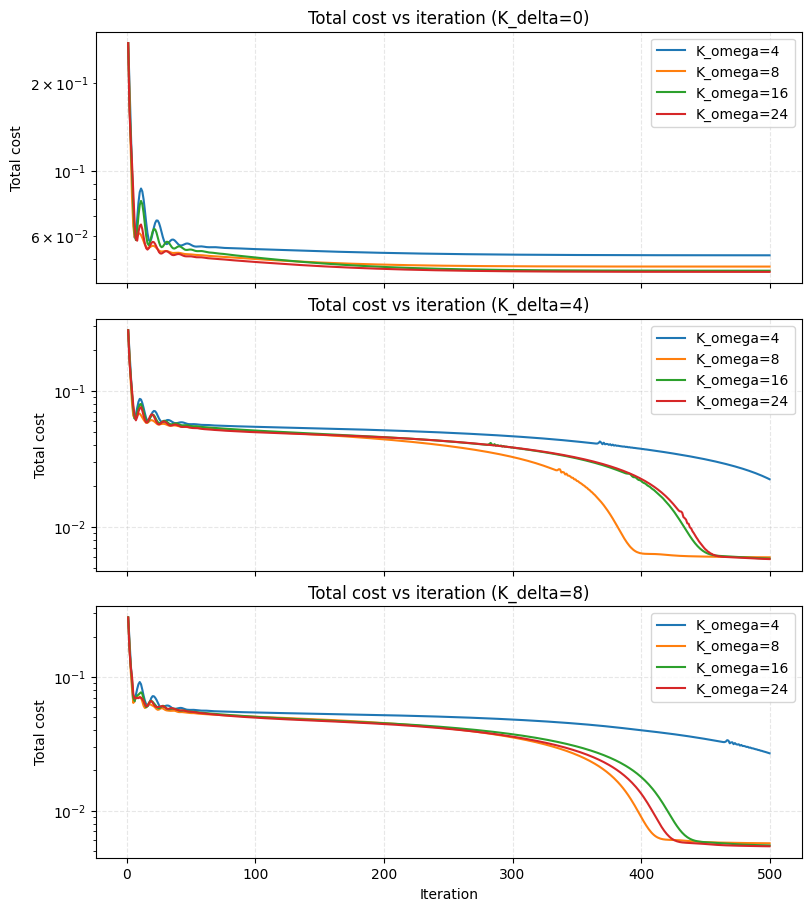

In [18]:
# Cost trajectories grouped by K_delta
if history_by_basis:
    fig, axes = plt.subplots(len(K_DELTA_VALUES), 1, figsize=(8, 3 * len(K_DELTA_VALUES)), sharex=True, constrained_layout=True)
    if len(K_DELTA_VALUES) == 1:
        axes = [axes]
    for idx, K_delta in enumerate(K_DELTA_VALUES):
        ax = axes[idx]
        for K_omega in K_OMEGA_VALUES:
            history = history_by_basis.get((K_omega, K_delta))
            if not history:
                continue
            total_series = history.get('cost_total')
            iter_series = history.get('iter')
            if total_series is None:
                continue
            x_axis = iter_series if iter_series is not None and iter_series.size == total_series.size else np.arange(total_series.size)
            ax.plot(x_axis, total_series, label=f'K_omega={K_omega}')
        ax.set_title(f'Total cost vs iteration (K_delta={K_delta})')
        ax.set_ylabel('Total cost')
        ax.set_yscale('log')
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.legend()
    axes[-1].set_xlabel('Iteration')
    plt.show()


## Pulse Comparisons

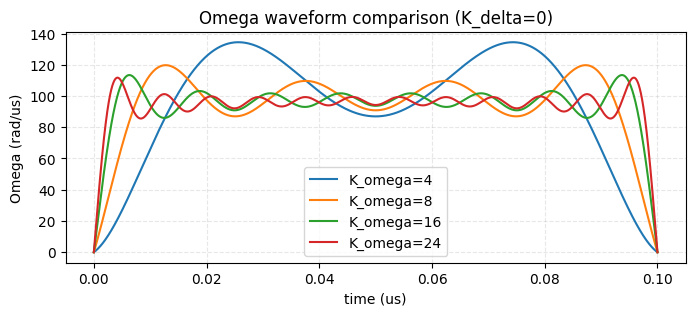

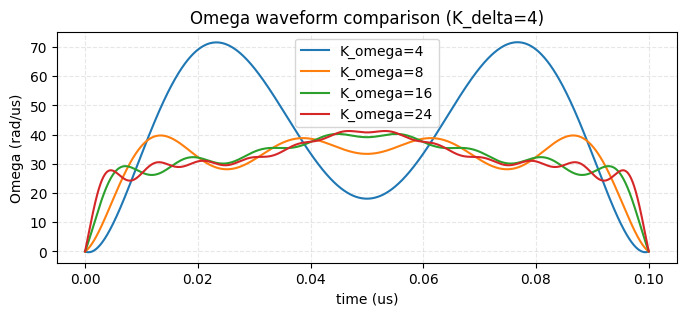

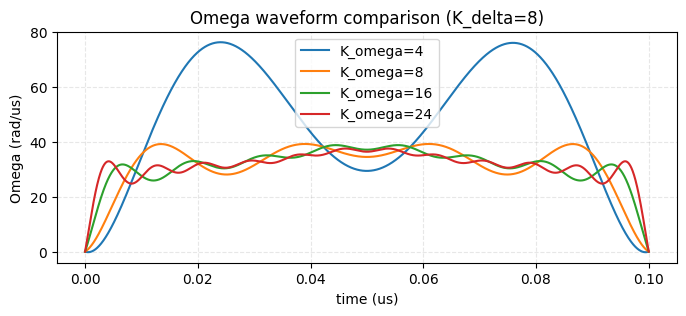

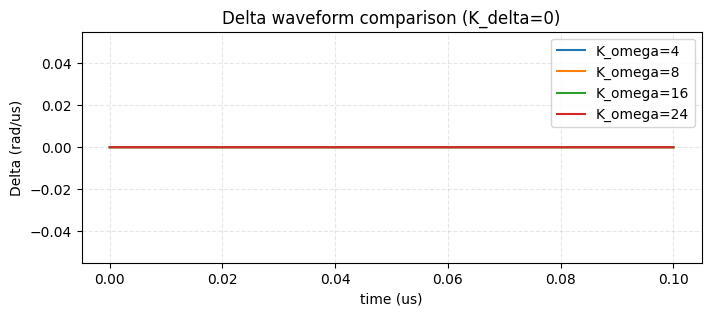

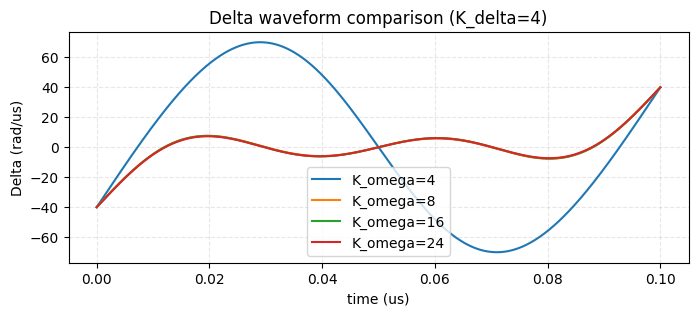

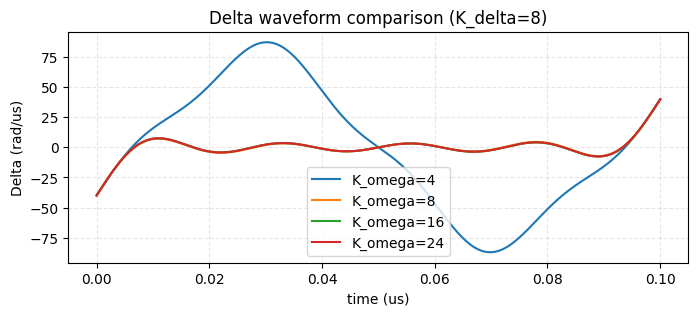

In [19]:
# Compare optimized pulses across basis sizes
if not pulses_by_basis:
    print('Run the sweep above before plotting pulses.')
else:
    for K_delta in K_DELTA_VALUES:
        fig, ax = plt.subplots(figsize=(8, 3))
        for K_omega in K_OMEGA_VALUES:
            pulses = pulses_by_basis.get((K_omega, K_delta))
            if not pulses:
                continue
            t_us = pulses.get('t_us')
            omega = pulses.get('omega')
            if t_us is None or omega is None or getattr(omega, 'size', 0) == 0:
                continue
            ax.plot(t_us, omega, label=f'K_omega={K_omega}')
        ax.set_title(f'Omega waveform comparison (K_delta={K_delta})')
        ax.set_xlabel('time (us)')
        ax.set_ylabel('Omega (rad/us)')
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.legend()
        plt.show()

    any_delta = any((p.get('delta') is not None and getattr(p.get('delta'), 'size', 0) > 0) for p in pulses_by_basis.values())
    if any_delta:
        for K_delta in K_DELTA_VALUES:
            fig, ax = plt.subplots(figsize=(8, 3))
            for K_omega in K_OMEGA_VALUES:
                pulses = pulses_by_basis.get((K_omega, K_delta))
                if not pulses:
                    continue
                t_us = pulses.get('t_us')
                delta = pulses.get('delta')
                if t_us is None or delta is None or getattr(delta, 'size', 0) == 0:
                    continue
                ax.plot(t_us, delta, label=f'K_omega={K_omega}')
            ax.set_title(f'Delta waveform comparison (K_delta={K_delta})')
            ax.set_xlabel('time (us)')
            ax.set_ylabel('Delta (rad/us)')
            ax.grid(True, linestyle='--', alpha=0.3)
            ax.legend()
            plt.show()
    else:
        print('No detuning waveforms were optimized (all K_delta = 0).')

## Aggregated Metrics

In [20]:
# Summaries grouped by basis size
if summary_df.empty:
    print('Run the sweep above before computing aggregates.')
else:
    metrics_cols = ['total_final', 'terminal_final', 'runtime_s']
    stats_by_delta = summary_df.groupby('K_delta')[metrics_cols].agg(['mean', 'min', 'max'])
    stats_by_omega = summary_df.groupby('K_omega')[metrics_cols].agg(['mean', 'min', 'max'])
    print('Aggregated metrics by K_delta:')
    print(stats_by_delta.round(6))
    print('Aggregated metrics by K_omega:')
    print(stats_by_omega.round(6))

Aggregated metrics by K_delta:
        total_final                     terminal_final                      \
               mean       min       max           mean       min       max   
K_delta                                                                      
0          0.047268  0.045107  0.051402       0.000055  0.000051  0.000063   
4          0.009949  0.005806  0.022147       0.000024  0.000005  0.000079   
8          0.010838  0.005426  0.026703       0.000032  0.000005  0.000114   

         runtime_s                        
              mean        min        max  
K_delta                                   
0        24.665153  24.469241  24.965085  
4        24.799032  24.331053  25.533880  
8        24.748763  24.199000  25.387705  
Aggregated metrics by K_omega:
        total_final                     terminal_final                      \
               mean       min       max           mean       min       max   
K_omega                                                

## Export Summaries

In [21]:
# Persist tabular data for reuse
if summary_df.empty:
    print('Run the sweep above before exporting summary tables.')
else:
    export_dir = (artifact_root / 'basis_capacity_sweep').resolve()
    export_dir.mkdir(parents=True, exist_ok=True)
    csv_path = export_dir / 'summary.csv'
    json_path = export_dir / 'summary.json'
    summary_df.to_csv(csv_path, index=False)
    summary_df.to_json(json_path, orient='records', indent=2)
    print(f'Wrote {csv_path}')
    print(f'Wrote {json_path}')

Wrote C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\artifacts\basis_capacity_sweep\summary.csv
Wrote C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\artifacts\basis_capacity_sweep\summary.json


## Further Exploration

- Extend robustness analysis by activating ensemble objectives or noise sweeps.
- Experiment with adaptive basis schedules (for example, increase K_omega during optimization).
- Integrate these results into reporting or automation once the sweep stabilizes.